In [14]:
from word_embedding.helper import vocabulary, co_occurence_matrix
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import numpy as np
#nltk.download('punkt', download_dir='data/input')

### Obtenir un Vocabulaire:

Cette fois, on va implémenter séparément une fonction retournant le vocabulaire. Il faudra ici pouvoir contrôler sa taille, que ce soit en indiquant un nombre maximum de mots, ou un nombre minimum d'occurences pour qu'on prenne en compte les mots: c'est cette deuxième idée qu'on suivra ici. Attention, il faudra auparavant **trier les mots par fréquences pour retirer en priorité les moins fréquents** ! On ajoute, à la fin, un mot "inconnu" qui remplacera tous les mots qui n'apparaissent pas dans notre vocabulaire 'limité'. Note: il n'est pas nécessaire de compter le nombre d'occurences des mots inconnus. On ajoutera simplement un dernier token ```UNK``` à la fin du vocabulaire, avec la fréquence ```1```. 

In [3]:
corpus = ['I walked down down the boulevard',
          'I walked down the avenue',
          'I ran down the boulevard',
          'I walk down the city',
          'I walk down the the avenue']

voc, counts = vocabulary(corpus, voc_threshold = 3)
print(voc)
print(counts)

{'down': 0, 'the': 1, 'i': 2, 'UNK': 3}
{'down': 6, 'the': 6, 'i': 5, 'UNK': 1}


### Obtenir les co-occurences:

La fonction prend en entrée le corpus (une liste de strings, correspondant aux documents, ou phrases) et un vocabulaire, ainsi que la taille de la fenêtre de contexte. On pourra aussi implémenter la solution la plus simple - que le contexte d'un mot soit le reste du document duquel il provient. 
Enfin, on pourra implémenter la possibilité de faire décroitre linéairement l'importance d'un mot du contexte à mesure qu'on s'éloigne du mot d'origine. 

In [4]:
print(co_occurence_matrix(corpus, voc, 0, False))

[[2. 7. 6. 0.]
 [7. 2. 6. 0.]
 [6. 6. 0. 0.]
 [0. 0. 0. 0.]]


#### Application à un vrai jeu de données

On va chercher à obtenir ces comptes pour les données du **20 newsgroup dataset**, un jeu de données qui contient environ 18000 posts sur 20 sujets différents, déjà divisé en données d'entraînement et de test (la séparation est faite selon la date des posts). Voir la documentation sur ```scikit-learn```: https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html

In [11]:
newsgroups_train = fetch_20newsgroups(data_home = 'data/input', subset='train')
newsgroups_test = fetch_20newsgroups(data_home = 'data/input', subset='test')

In [7]:
print(len(newsgroups_train['data']))
print(len(newsgroups_test['data']))

11314
7532


In [8]:
print(newsgroups_train['data'][0])
print(newsgroups_train['target'][0])
print(newsgroups_train.target_names[newsgroups_train['target'][0]])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





7
rec.autos


#### Etude rapide des données

On voudrait ici, avant de procéder, avoir une idée de ce que contiennent ces critiques de films. On va donc obtenir le vocabulaire (entier) et représenter les fréquences des mots, dans l'ordre (attention, il faudra utiliser une échelle logarithmique): on devrait retrouver la loi de Zipf. Cela nous permettra d'avoir une idée de la taille du vocabulaire qu'on pourra choisir : il s'agit de réaliser un compromis entre les ressources nécessaires (taille des objets en mémoire) et quantité d'informations qu'on peut en tirer (les mots rares peuvent apporter beaucoup d'informations, mais il est difficile d'en apprendre de bonnes représentations,car ils sont rares !)  

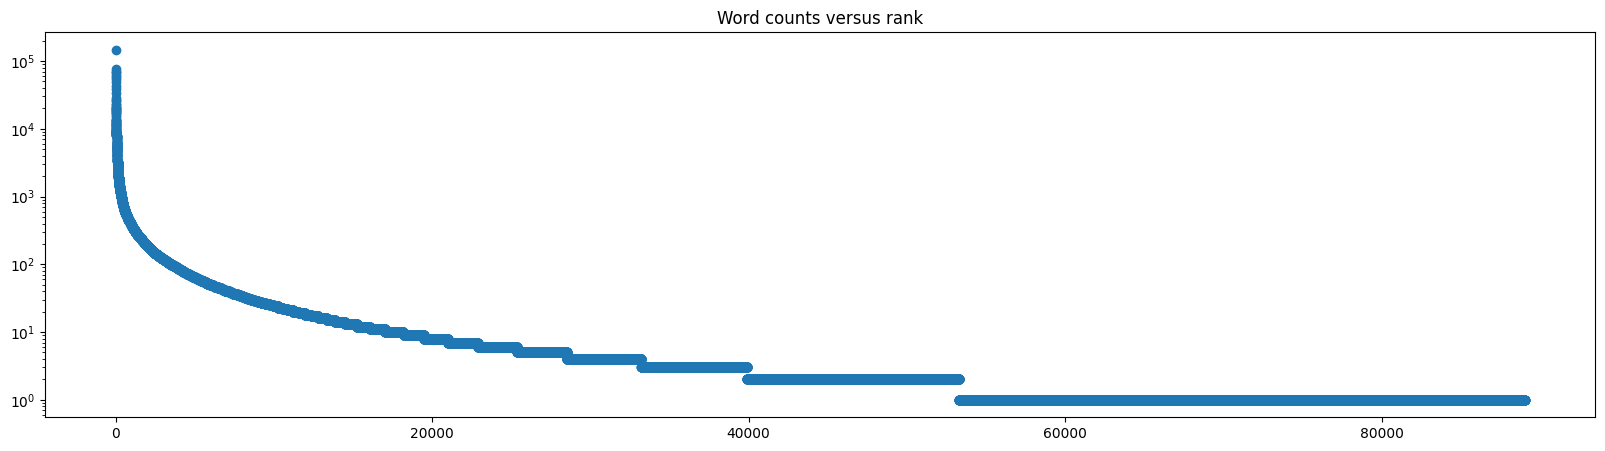

Vocabulary size: 89039
Part of the corpus by taking the "x" most frequent words?
Proportion of the corpus represented by the 1000 most frequent words: 0.6972


In [15]:
texts = newsgroups_train['data']
vocab, word_counts = vocabulary(texts)

sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
counts = [count for _, count in sorted_word_counts]

plt.figure(figsize=(20, 5))
plt.title('Word counts versus rank')
plt.scatter(range(len(counts)), counts)
plt.yscale('log')
plt.show()

# We would like to know how much of the data is represented by the 'k' most frequent words
print('Vocabulary size: %i' % len(vocab))
print('Part of the corpus by taking the "x" most frequent words?')

k = 1000
cumulative_counts = np.cumsum(counts)
total_words = np.sum(counts)
corpus_part = cumulative_counts[k - 1] / total_words

print(f'Proportion of the corpus represented by the {k} most frequent words: {corpus_part:.4f}')

Résultat de l'analyse: on peut se contenter d'un vocabulaire de 10000, voire 5000 mots - c'est important, car cela va déterminer la taille des objets que l'on va manipuler. On va maintenant recréer la matrice de co-occurence avec différents paramètres. Cela peut-être long: si cela pose problème, travaillez avec un vocabulaire plus réduit.

In [19]:
corpus = newsgroups_train['data']
vocab_5k, word_counts_5k = vocabulary(corpus, 5000)
M5dist = co_occurence_matrix(corpus, vocab_5k, window=5, distance_weighting=True)
M20 = co_occurence_matrix(corpus, vocab_5k, window=20, distance_weighting=False)
print(M5dist.shape)
print(M20.shape)

(5001, 5001)
(5001, 5001)


In [20]:
print(vocab_5k['politics'])
print(M5dist[1968])
print(M20[1968])

1968
[0.59053643 0.86794259 0.41702036 ... 0.         0.         0.        ]
[281. 200. 172. ...   0.   0.   0.]


### Comparaison de vecteurs

On peut se servir de ces vecteurs de très grande taille pour une analyse sémantique très basique: par exemple, en cherchant les plus proches voisins d'un mot. Cependant, il faudra faire attention aux distances qu'on utilise, liées à certaines métriques (Euclidiennes, Cosine) ou éventuellement d'autres liées à l'appartenance aux ensembles (Matching, Jaccard). La normalisation des vecteurs peut aussi jouer un rôle. Dans tous les cas, il faut bien faire attention à ne pas sur-interprêter ce type de résultats. 